In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib  # For saving the model


In [2]:
# Step 2: Load the Dataset
df = pd.read_csv("/content/Harvest_Prediction_Factors_Merged.csv")  # Update path if needed


In [3]:
# Step 3: Encode Categorical Variables
label_encoders = {}
categorical_features = ['Paddy Variety', 'Soil Type', 'Irrigation Type', 'Water Source', 'Pest Severity', 'Season', 'District']

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for future decoding

# Step 4: Define Features & Target Variable
X = df.drop(columns=[" Yield (kg)"])  # Ensure column name matches exactly
y = df[" Yield (kg)"]

In [4]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train XGBoost Regressor Model
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [5]:
# Step 7: Model Evaluation
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print(f"🔹 XGBoost R² (Train): {r2_train:.4f}")
print(f"🔹 XGBoost R² (Test): {r2_test:.4f}")
print(f"🔹 Mean Absolute Error: {mae:.2f}")
print(f"🔹 Mean Squared Error: {mse:.2f}")

🔹 XGBoost R² (Train): 0.9935
🔹 XGBoost R² (Test): 0.9753
🔹 Mean Absolute Error: 460.79
🔹 Mean Squared Error: 4355576.82


In [6]:
# Step 8: Save the Model
joblib.dump(xgb_model, "xgb_paddy_yield_model.pkl")

# Step 9: Load Model for Prediction
xgb_model = joblib.load("xgb_paddy_yield_model.pkl")


In [7]:
# Function to Predict Yield
# Function to Predict Yield with Comparison
def predict_yield():
    input_features = X.columns.tolist()  # Get the correct feature list

    user_data = {}
    for feature in input_features:
        if feature in categorical_features:
            user_data[feature] = input(f"Enter {feature}: ")
        else:
            user_data[feature] = float(input(f"Enter {feature}: "))

    # Include "Previous Yield (kg/ha)" for comparison
    previous_yield = float(input("Enter Previous Yield (kg/ha): "))

    # Convert input to DataFrame
    user_df = pd.DataFrame([user_data])

    # Encode categorical features
    for col in categorical_features:
        if col in user_df:
            if user_df[col][0] in label_encoders[col].classes_:
                user_df[col] = label_encoders[col].transform([user_df[col][0]])[0]
            else:
                print(f"⚠️ Warning: Unknown category '{user_df[col][0]}' for feature '{col}'. Assigning default value.")
                user_df[col] = -1  # Assign an unknown value

    # Ensure feature names match the trained model
    user_df = user_df[X.columns]

    # Predict Yield
    predicted_yield = xgb_model.predict(user_df)[0]

    print("=========================")
    print(f"🌾 Predicted Harvest Yield: {predicted_yield:.2f} kg/ha")
    print("=========================")

    # Provide recommendations based on yield comparison
    if previous_yield > predicted_yield:
        print("⚠️ Warning: Your predicted yield is lower than the previous yield.")
        print("🔹 Recommendations:")
        print("- Optimize fertilizer usage based on soil tests.")
        print("- Improve irrigation practices for consistent water supply.")
        print("- Consider pest control measures to minimize yield loss.")
        print("- Use high-yield paddy varieties suitable for the district.")
        print("- Apply balanced soil nutrients and organic matter.")
    else:
        print("✅ Your yield is expected to be stable or improve!")
        print("🔹 Recommendations for Further Improvement:")
        print("- Continue current agricultural practices.")
        print("- Monitor soil health and apply nutrients accordingly.")
        print("- Use precision farming tools to track crop progress.")
        print("- Plan for seasonal crop rotation to maintain soil fertility.")
        print("- Use modern harvesting techniques to reduce post-harvest losses.")



In [ ]:

# Run Prediction
predict_yield()

Enter Rainfall (mm): 900
Enter Temperature (°C): 34
Enter Relative Humidity (%): 66
Enter Sunshine Hours (hrs): 12
Enter Wind Speed (km/h): 10
Enter Soil Type: Sandy
Enter Irrigation Type: Rainfed
Enter Water Source: Well
Enter Paddy Variety: BG 450
Enter Fertilizer Usage (kg): 34
Enter Area (hectare): 56
Enter Soil Nitrogen (mg/kg): 34
Enter Soil Phosphorus (mg/kg): 34
Enter Soil Potassium (mg/kg): 67
Enter Pest Severity: Low
Enter Season: Yala
Enter District: Ampara
Enter Previous Yield (kg/ha): 2345
🌾 Predicted Harvest Yield: 35488.78 kg/ha
✅ Your yield is expected to be stable or improve!
🔹 Recommendations for Further Improvement:
- Continue current agricultural practices.
- Monitor soil health and apply nutrients accordingly.
- Use precision farming tools to track crop progress.
- Plan for seasonal crop rotation to maintain soil fertility.
- Use modern harvesting techniques to reduce post-harvest losses.


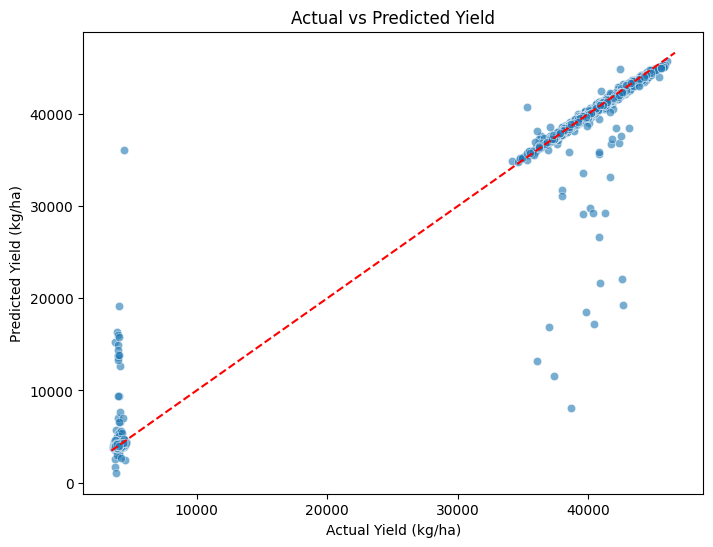

In [8]:
# Predictions vs Actuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='dashed')
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title("Actual vs Predicted Yield")
plt.show()

<Figure size 1000x600 with 0 Axes>

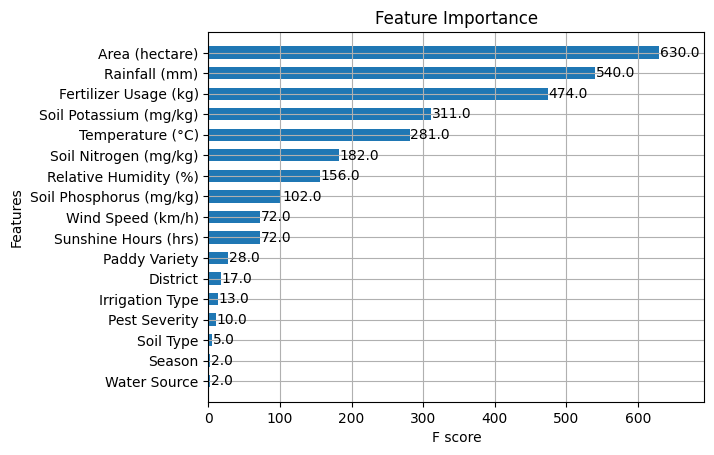

In [9]:
# Step 10: Data Visualization 📊
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, height=0.6, importance_type="weight")
plt.title("Feature Importance")
plt.show()

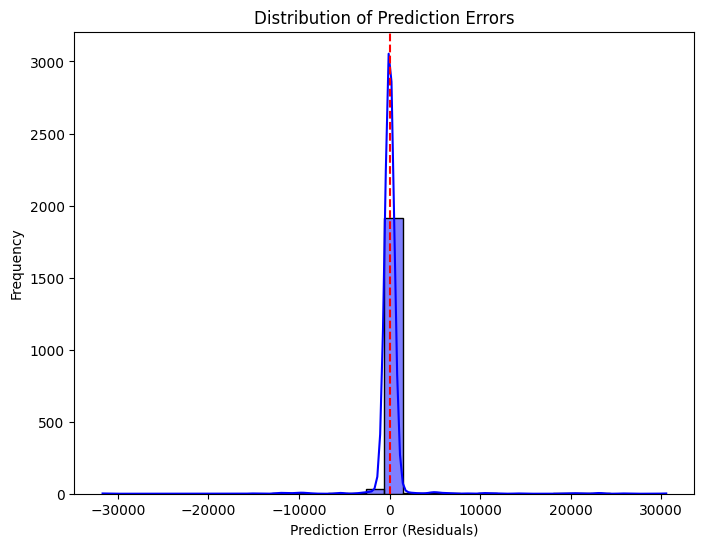

In [10]:
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


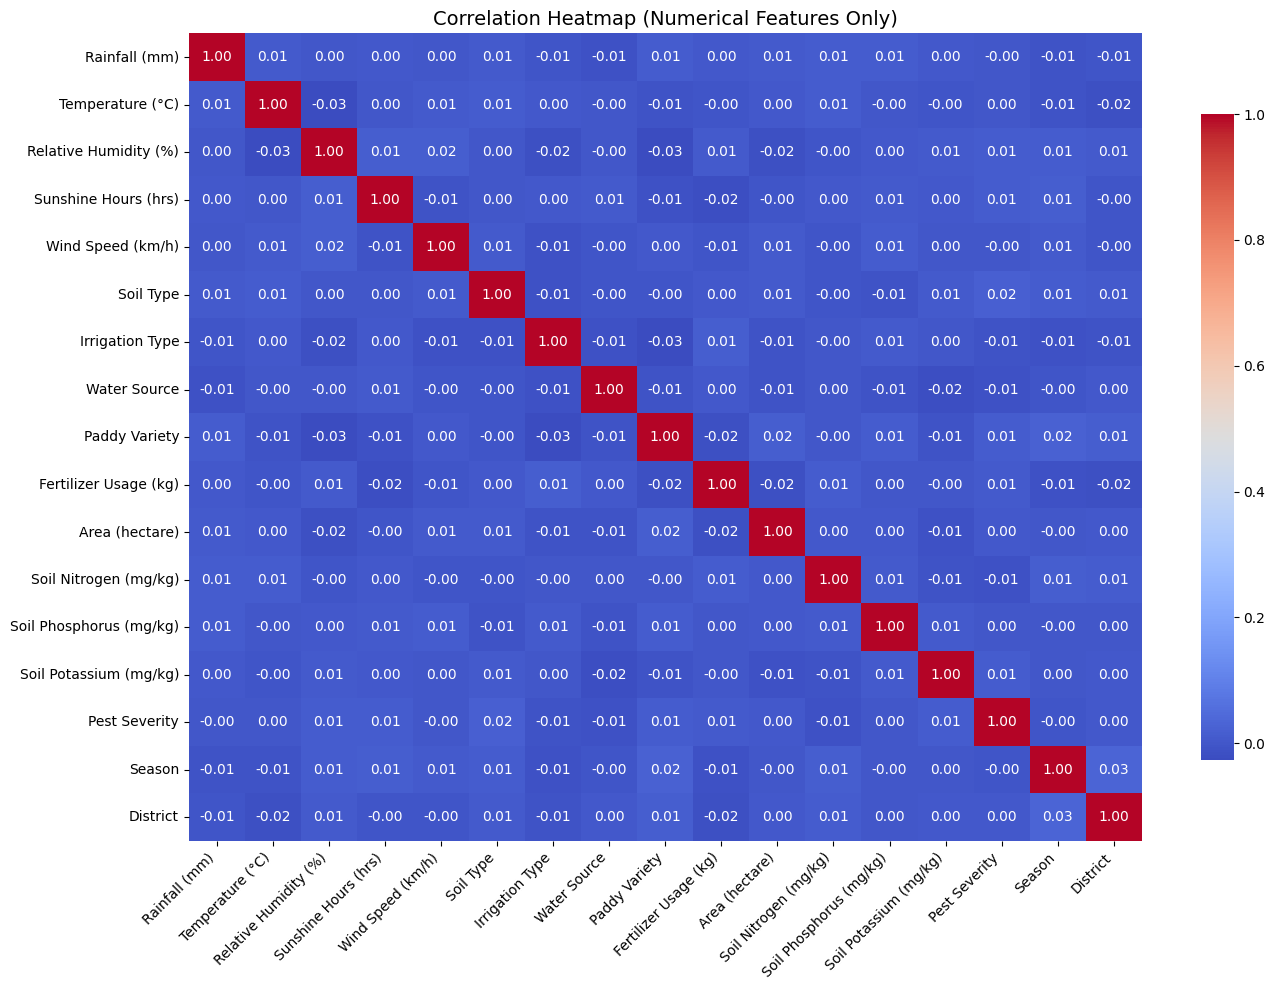

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_X = X.select_dtypes(include=['int64', 'float64'])

# Create correlation matrix and plot heatmap
plt.figure(figsize=(14, 10))  # Bigger size for clarity
heatmap = sns.heatmap(
    numerical_X.corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8}
)

# Improve label readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap (Numerical Features Only)", fontsize=14)
plt.tight_layout()
plt.show()
